In [ ]:
from torch.utils.data import DataLoader,Dataset
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_data = datasets.MNIST(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data = datasets.MNIST(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 908kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.48MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class VarAutoencoder(torch.nn.Module):
    def __init__(self):
        super(VarAutoencoder,self).__init__()
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.flatten = torch.nn.Flatten()
        self.unflatten = torch.nn.Unflatten(1,(1,28,28))
        self.fc1 = torch.nn.Linear(784,256)
        self.fc2 = torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,128)
        self.mu = torch.nn.Linear(128,128)
        self.log_var = torch.nn.Linear(128,128)
        self.fc5 = torch.nn.Linear(128,256)
        self.fc6 = torch.nn.Linear(256,256)
        self.fc7 = torch.nn.Linear(256,256)
        self.fc8 = torch.nn.Linear(256,784)

    def forward(self,x):
        x,mu,log_var = self.encode(x)
        x = self.reparameterize(mu,log_var)
        x = self.decode(x)
        return x,mu,log_var
    def encode(self,x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return x,mu,log_var
    def decode(self,x):
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        x = self.relu(x)
        x = self.fc8(x)
        x = self.sigmoid(x)
        x = self.unflatten(x)
        return x
    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

In [ ]:
model = VarAutoencoder().to(device)
epochs = 10
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.BCELoss(reduction='sum')

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    for data in tqdm(train_loader):
        img,label = data
        img = img.to(device)
        output,mu,log_var = model(img)
        bce_loss = criterion(output,img)

        loss = bce_loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'epoch: {epoch}, loss: {train_loss}')

100%|██████████| 938/938 [00:11<00:00, 84.84it/s] 


epoch: 0, loss: 9794693.303710938


100%|██████████| 938/938 [00:09<00:00, 103.58it/s]


epoch: 1, loss: 6680441.7099609375


100%|██████████| 938/938 [00:08<00:00, 111.64it/s]


epoch: 2, loss: 5978635.914306641


100%|██████████| 938/938 [00:08<00:00, 105.19it/s]


epoch: 3, loss: 5559930.072998047


100%|██████████| 938/938 [00:08<00:00, 104.36it/s]


epoch: 4, loss: 5193773.470214844


100%|██████████| 938/938 [00:08<00:00, 105.13it/s]


epoch: 5, loss: 4972827.432861328


100%|██████████| 938/938 [00:09<00:00, 103.23it/s]


epoch: 6, loss: 4840412.5341796875


100%|██████████| 938/938 [00:09<00:00, 98.06it/s] 


epoch: 7, loss: 4737460.615234375


100%|██████████| 938/938 [00:08<00:00, 105.56it/s]


epoch: 8, loss: 4631373.21875


100%|██████████| 938/938 [00:08<00:00, 105.90it/s]

epoch: 9, loss: 4540731.064453125


(64, 1, 28, 28)


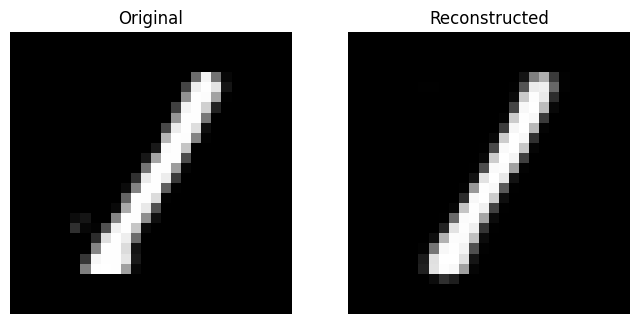

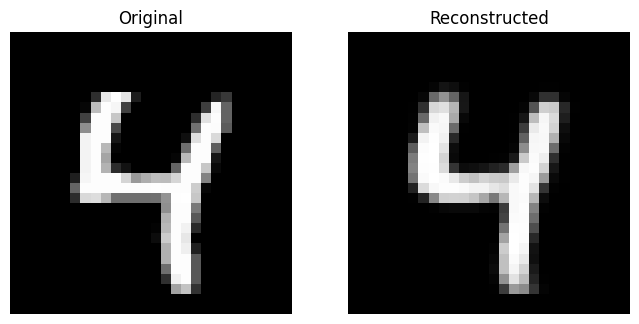

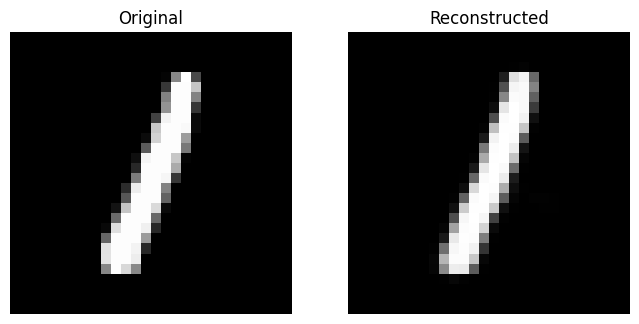

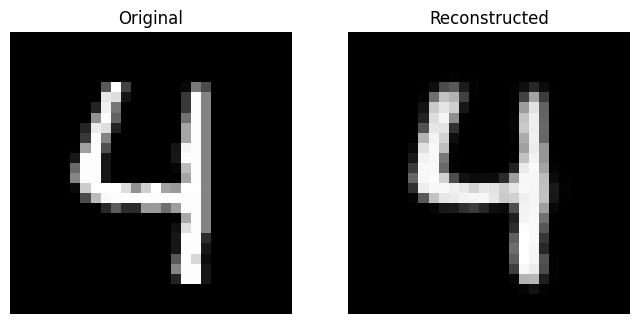

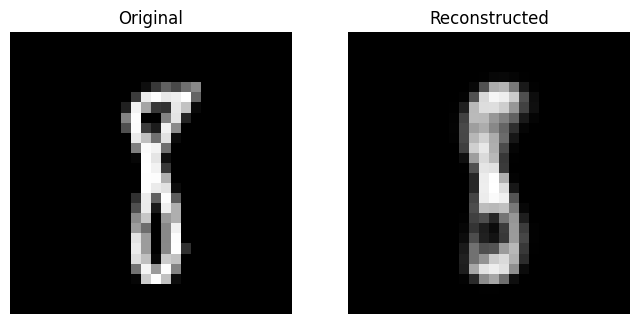

In [ ]:
data_iter = iter(train_loader)
images,labels = next(data_iter)

with torch.no_grad():
    output,mu,log_var = model(images.to(device))
    output = output.cpu()
    output = output.numpy()
    print(output.shape)
    output = np.reshape(output,(64,28,28))



for j in range(5):
    image = images[j].numpy()
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image[0], cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(output[j], cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

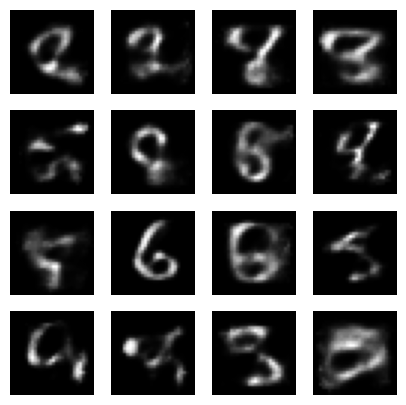

In [ ]:
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = model.decode(z).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")
plt.show()
